In [1]:
#!git clone https://github.com/facebookresearch/segment-anything-2
#%cd segment-anything-2
#!pip install -q -e .

In [2]:
%cd segment-anything-2

/home/vik0t/hackaton/segment-anything-2


In [3]:
import os
import pandas as pd
import cv2
import torch
import torch.nn.utils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
import json
import sys
import random
import torch.nn.functional as F

from ultralytics import YOLO
import pycocotools
import pycocotools.mask
from pycocotools import _mask
from PIL import Image
import torch
from torch.utils.data import DataLoader
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from PytorchWildlife.models import detection as pw_detection
from PytorchWildlife.data import transforms as pw_trans
from PytorchWildlife.data import datasets as pw_data
from PytorchWildlife import utils as pw_utils
import hydra
import matplotlib.image as mpimg

with open("/home/vik0t/hackaton/segment-anything-2/gray_val.json", "r") as f:
  val_data = json.load(f)

with open("/home/vik0t/hackaton/segment-anything-2/gray_train.json", "r") as f:
  train_data = json.load(f)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results


wandb: Enter your choice: (30 second timeout) 

wandb: You chose "Don't visualize my results"


Зафиксировать seed для воспроизведения обучения.

In [4]:
def set_seeds():
    SEED_VALUE = 42
    random.seed(SEED_VALUE)
    np.random.seed(SEED_VALUE)
    torch.manual_seed(SEED_VALUE)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(SEED_VALUE)
        torch.cuda.manual_seed_all(SEED_VALUE)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

set_seeds()

## Считывание данных для обучения

In [5]:
def read_batch(data, data_path):
   # Select a random entry
  ent = data['annotations'][np.random.randint(len(data['annotations']))]

  ind = 0
  for i in range(len(data['images'])):
     if data['images'][i]['id'] == ent['image_id']:
        ind=i
        break
  image_path = data['images'][ind]['file_name']
  image_path = os.path.join(data_path, image_path)
  Img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
  binary_mask = np.zeros((693, 1344), dtype=np.uint8)
  for pts in ent['segmentation']:
    # Шаг 1: Разделить на пары (x, y)
    points = [[pts[i], pts[i + 1]] for i in range(0, len(pts), 2)]

    # Шаг 2: Обернуть в список (даже если один полигон)
    polygon = [points]

    # Шаг 3: Преобразовать в NumPy массив с типом int32
    pts_array = np.array(polygon, dtype=np.int32)
    cv2.fillPoly(binary_mask, pts_array , color=1)

  # Erode the combined binary mask to avoid boundary points
  eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

  points = []
  # Get all coordinates inside the eroded mask and choose random points
  coords = np.argwhere(eroded_mask > 0)
  if len(coords) > 0:
      yx = coords[np.random.randint(len(coords))]  # Randomly select a point
      points.append([yx[1], yx[0]])  # Append in [x, y] format (col, row)

  points = np.array(points)
  binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
  binary_mask = binary_mask.transpose((2, 0, 1))
  points = np.expand_dims(points, axis=1)

  # Return the image, binarized mask, points, and number of masks
  return Img, binary_mask, points, 1

## Подготовка кода для обучения

In [6]:
sam2_checkpoint = "sam2.1_hiera_base_plus.pt"  # @param ["sam2_hiera_tiny.pt", "sam2_hiera_small.pt", "sam2_hiera_base_plus.pt", "sam2_hiera_large.pt"]
model_cfg = "sam2.1_hiera_b+.yaml" # @param ["sam2_hiera_t.yaml", "sam2_hiera_s.yaml", "sam2_hiera_b+.yaml", "sam2_hiera_l.yaml"]

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")
predictor = SAM2ImagePredictor(sam2_model)

Loaded checkpoint sucessfully
Loaded checkpoint sucessfully


In [7]:
# Train mask decoder.
predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.model.sam_prompt_encoder.train(True)

# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.model.parameters(),lr=0.0001,weight_decay=1e-4) #1e-5, weight_decay = 4e-5

# Mix precision.
scaler = torch.amp.GradScaler("cuda")

# No. of steps to train the model.
NO_OF_STEPS = 30000 # @param
accumulation_steps = 4  # Number of steps to accumulate gradients before updating
# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2"

# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1) # 500 , 250, gamma = 0.1

train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []
best_f1 = 0

In [8]:
def train(predictor, train_data, step, mean_iou):    
    with torch.amp.autocast(device_type='cuda'):
        image, mask, input_point, num_masks = read_batch(train_data, '/home/vik0t/hackaton/segment-anything-2/data1/train/images')
        if image is None or mask is None or num_masks == 0:
            return 0
        input_label = np.ones((num_masks, 1))
        if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
            return 0
        if input_point.size == 0 or input_label.size == 0:
            return 0
        image = image.copy()
        predictor.set_image(image)
        mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
            input_point, input_label, box=None, mask_logits=None, normalize_coords=True
        )
         
        if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
            return
 
        sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
            points=(unnorm_coords, labels), boxes=None, masks=None
        )
 
        batched_mode = unnorm_coords.shape[0] > 1
        high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
 
        low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
            image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
            image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
            sparse_prompt_embeddings=sparse_embeddings,
            dense_prompt_embeddings=dense_embeddings,
            multimask_output=True,
            repeat_image=batched_mode,
            high_res_features=high_res_features,
        )
 
        prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])
         
        gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
        prd_mask = torch.sigmoid(prd_masks[:, 0])
         
        seg_loss = (-gt_mask * torch.log(prd_mask + 1e-6) - (1 - gt_mask) * torch.log((1 - prd_mask) + 1e-6)).mean()
         
        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
       
        score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
        loss = seg_loss + score_loss * 0.05
        loss = loss / accumulation_steps
        

        scaler.scale(loss).backward()
         
        torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)
         
        scheduler.step() 
        
        if step % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            predictor.model.zero_grad()
 
       
         
        mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
        train_f1_scores.append(mean_iou) 
        train_losses.append(seg_loss.detach().cpu().numpy())
        
        if step % 100 == 0:
            current_lr = optimizer.param_groups[0]["lr"]
            print(f"Step {step}: Current LR = {current_lr:.8f}, IoU = {mean_iou:.6f}, Seg Loss = {seg_loss:.6f}")
    return mean_iou

In [9]:
def validate(predictor, val_data, step, mean_iou):
    global best_f1
    predictor.model.eval()
    with torch.amp.autocast(device_type='cuda'):
        with torch.no_grad():
            image, mask, input_point, num_masks = read_batch(val_data, '/home/vik0t/hackaton/segment-anything-2/data1/val/images')
            if image is None or mask is None or num_masks == 0:
                return

            input_label = np.ones((num_masks, 1))
            if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
                return
               
            if input_point.size == 0 or input_label.size == 0:
                return
            image = image.copy()
            predictor.set_image(image)
            mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(
                input_point, input_label, box=None, mask_logits=None, normalize_coords=True
            )
             
            if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
                return
     
            sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
                points=(unnorm_coords, labels), boxes=None, masks=None
            )
 
            batched_mode = unnorm_coords.shape[0] > 1
            high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
            low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
                image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
                image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
                sparse_prompt_embeddings=sparse_embeddings,
                dense_prompt_embeddings=dense_embeddings,
                multimask_output=True,
                repeat_image=batched_mode,
                high_res_features=high_res_features,
            )
 
            prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])
 
            gt_mask = torch.tensor(mask.astype(np.float32)).cuda()
            prd_mask = torch.sigmoid(prd_masks[:, 0])
 
            seg_loss = (-gt_mask * torch.log(prd_mask + 1e-6)
                        - (1 - gt_mask) * torch.log((1 - prd_mask) + 1e-6)).mean()
 
            inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
            iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
 
            score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
            loss = seg_loss + score_loss * 0.05
            loss = loss / accumulation_steps

            if step % 1000 == 0:
                FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".pt"
                torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)
             
            mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
            val_f1_scores.append(mean_iou)
            val_losses.append(seg_loss.detach().cpu().numpy())
            
            if step > 300 and mean_iou > best_f1:
                FINE_TUNED_MODEL = "BEST" + ".pt"
                torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)
                best_f1 = mean_iou

            if step % 100 == 0:
                current_lr = optimizer.param_groups[0]["lr"]
                print(f"Step {step}: Current LR = {current_lr:.8f}, Valid_IoU = {mean_iou:.6f}, Valid_Seg Loss = {seg_loss:.6f}")
    return mean_iou

In [ ]:
train_mean_iou = 0
valid_mean_iou = 0
 
for step in range(1, NO_OF_STEPS + 1):
    train_mean_iou = train(predictor, train_data, step, train_mean_iou)
    valid_mean_iou = validate(predictor, val_data, step, valid_mean_iou)

In [ ]:
#from sam_class import fine_tuned_sam
#
#model = fine_tuned_sam(model_cfg, sam2_checkpoint, scheduler, accumulation_steps)
#model.train(30000, optimizer, train_data, val_data)

Loaded checkpoint sucessfully
Loaded checkpoint sucessfully
For numpy array image, we assume (HxWxC) format
For numpy array image, we assume (HxWxC) format
Computing image embeddings for the provided image...
Computing image embeddings for the provided image...
Image embeddings computed.
Image embeddings computed.
For numpy array image, we assume (HxWxC) format
For numpy array image, we assume (HxWxC) format
Computing image embeddings for the provided image...
Computing image embeddings for the provided image...
Image embeddings computed.
Image embeddings computed.
For numpy array image, we assume (HxWxC) format
For numpy array image, we assume (HxWxC) format
Computing image embeddings for the provided image...
Computing image embeddings for the provided image...
Image embeddings computed.
Image embeddings computed.
For numpy array image, we assume (HxWxC) format
For numpy array image, we assume (HxWxC) format
Computing image embeddings for the provided image...
Computing image embeddi

AssertionError: No inf checks were recorded for this optimizer.

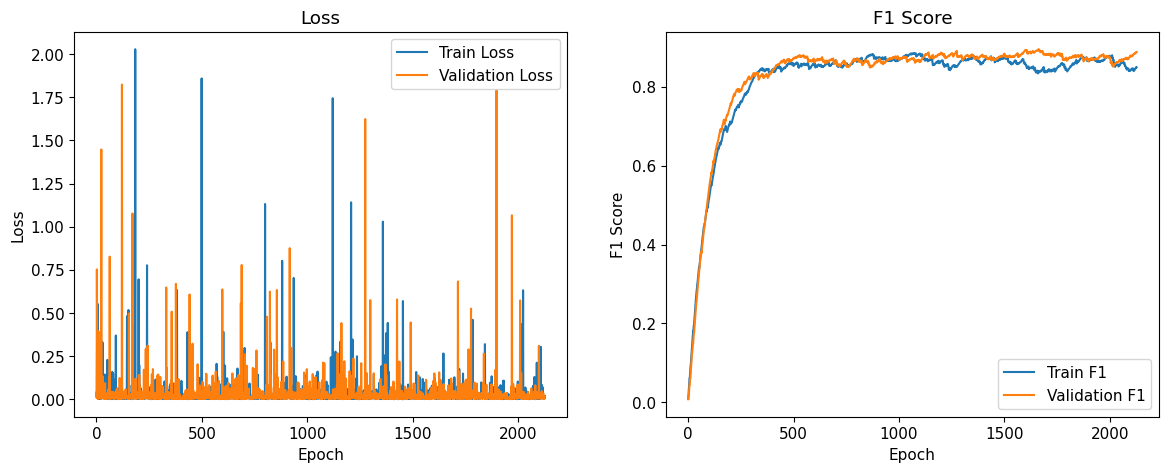

In [ ]:
%matplotlib inline
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_f1_scores, label='Train F1')
plt.plot(val_f1_scores, label='Validation F1')
plt.title('F1 Score')
plt.xlabel('Iteration')
plt.ylabel('F1 Score')
plt.legend()

plt.show()

In [ ]:
best_f1

np.float32(0.8953134)

In [ ]:
from visualize import show_box
from visualize import show_mask
from visualize import show_masks
from visualize import show_points

In [ ]:
checkpoint = "/home/vik0t/hackaton/segment-anything-2/sam2.1_hiera_base_plus.pt"
model_cfg = "sam2.1_hiera_b+.yaml"
predictor = SAM2ImagePredictor(build_sam2(model_cfg, checkpoint))
FINE_TUNED_MODEL_WEIGHTS = "/home/vik0t/hackaton/segment-anything-2/fine_tuned_sam2_13500.pt"
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

INFO:root:Loaded checkpoint sucessfully
Loaded checkpoint sucessfully
Loaded checkpoint sucessfully


<All keys matched successfully>

In [ ]:
detection_model = pw_detection.MegaDetectorV6(pretrained=True, version="MDV6-yolov10-e")

In [ ]:
test_image_path = "/home/vik0t/hackaton/test_images/0a79f28c5bdb6b596f220377ade79bf2 copy.JPG"

In [ ]:
results_md = detection_model.single_image_detection(test_image_path)
results_md['detections'].xyxy[0].tolist()

img=cv2.imread(test_image_path)
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    predictor.set_image(img)
    masks, scores, _ = predictor.predict(box=results_md['detections'].xyxy[0])
mask=masks[0]
score=scores[0]

Ultralytics 8.3.83 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
YOLOv10x summary (fused): 215 layers, 31,589,858 parameters, 0 gradients, 169.8 GFLOPs

0: 352x640 2 animals, 30.1ms
Speed: 1.6ms preprocess, 30.1ms inference, 1.9ms postprocess per image at shape (1, 3, 352, 640)


[896.2324829101562, 285.11187744140625, 1127.1094970703125, 441.61956787109375]

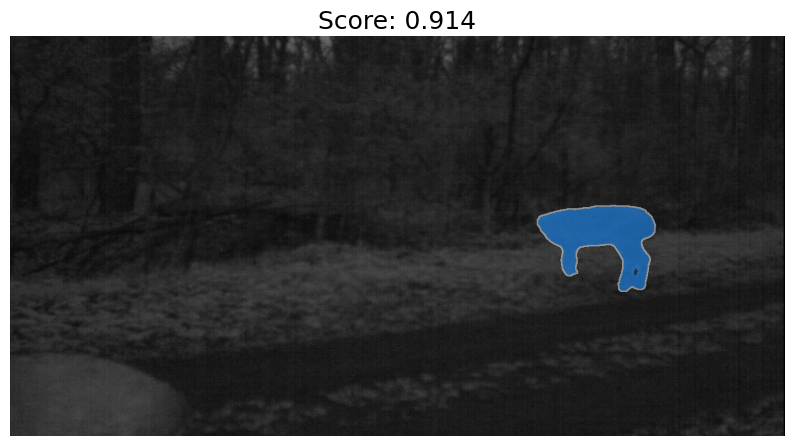

In [ ]:
%matplotlib inline
show_masks(img, mask, score)

loading annotations into memory...
Done (t=3.23s)
creating index...
index created!


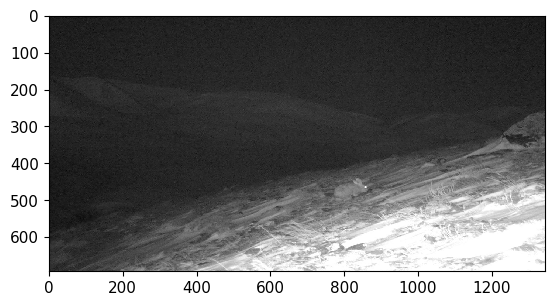

In [ ]:
from pycocotools.coco import COCO


coco = COCO('/home/vik0t/hackaton/segment-anything-2/gray_train.json')
img_dir = '/home/vik0t/hackaton/segment-anything-2/data1/train/images'
image_id = 500

img = coco.imgs[image_id]
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image, interpolation='nearest')
plt.show()

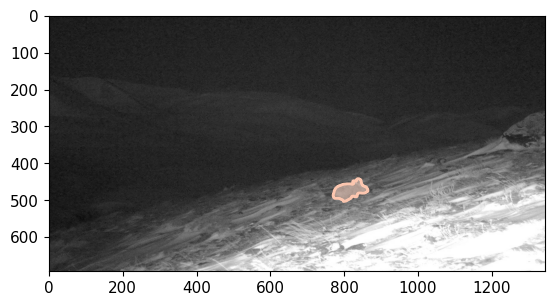

In [ ]:
plt.imshow(image)
anns_ids = coco.getAnnIds(imgIds=img['id'], iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)

## Установка необходимых библиотек для инференса Megadetecter

In [ ]:
tgt_folder_path = "test"
results_md = detection_model.batch_image_detection(tgt_folder_path, batch_size=16)

In [ ]:
results_md[0]

In [ ]:
from pycocotools import mask as coco_mask
def masks_to_rle(binary_mask):
    """
    Convert binary_mask to COCO RLE format.

    Args:
        binary_mask.

    Returns:
        list: List of RLE-encoded masks.
    """
    binary_mask = binary_mask.astype(np.uint8)

    # Encode mask using COCO RLE format
    rle = coco_mask.encode(np.asfortranarray(binary_mask))

    print(rle)
    # Ensure COCO compliance
    rle['counts'] = rle['counts']


    return rle

In [ ]:
results_md[0]['detections']

In [ ]:
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device="cuda")

predictor = SAM2ImagePredictor(sam2_model)
FINE_TUNED_MODEL_WEIGHTS = "/content/segment-anything-2/fine_tuned_sam2_3000.torch"
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

image_path = results_md[0]['img_id']
Img = cv2.imread(image_path)[..., ::-1]

with torch.no_grad():
   image = Img.copy()
   predictor.set_image(image)
   cx = (results_md[0]['detections'].xyxy[0][0] + results_md[0]['detections'].xyxy[0][2])/2
   cy = (results_md[0]['detections'].xyxy[0][1] + results_md[0]['detections'].xyxy[0][3])/2
   input_points = np.array([[cx, cy]])
   masks, scores, logits = predictor.predict(
       point_coords=[input_points],
       point_labels=np.ones([input_points.shape[0], 1])
   )

In [ ]:

import numpy as np

predictions = []
for result in results_md:
  if len(result['normalized_coords']) != 0:
    image_path = result['img_id']
    Img = cv2.imread(image_path)[..., ::-1]
    # Perform inference and predict masks
    with torch.no_grad():
      image = Img.copy()
      predictor.set_image(image)
      for detection in result['detections'].xyxy:
        cx = (detection[0] + detection[2])/2
        cy = (detection[1] + detection[3])/2
        input_points = np.array([[cx, cy]])
        masks, scores, logits = predictor.predict(
            point_coords=[input_points],
            point_labels=np.ones([input_points.shape[0], 1])
        )
        rle = masks_to_rle(masks[0])
        file_name = result['img_id'].split('/')[-1]
        predictions.append({
            "image_name": file_name,
            "category_id": "0",  # ID категории
            "bbox": detection,  # Координаты bounding box
            "score": scores[0],  # Оценка уверенности
            "segmentation": {
                "size" : rle["size"],
                "counts" : str(rle["counts"])
            }  # Сегментация в формате RLE
        })

In [ ]:
import os
import json

output_folder = "./"
# Сохранение предсказаний в JSON
predictions_file = os.path.join(output_folder, "submission.json")
with open(predictions_file, "w") as f:
    json.dump(predictions, f, indent=4)

print(f"Обработка завершена. Результаты сохранены в папке: {output_folder}")

NameError: name 'predictions' is not defined